## CNN model for hard onset detection

In [1]:
# Autoload libraries
%load_ext autoreload
%autoreload 2

# Main libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import madmom
import mir_eval

# Pre- and postprocessing
from modules.analysis_funcs import get_segmented_data, get_test_peaks
# Dataset handler
from datasets import Dataset
# Model
from models import FINAL_MODEL_PATH
# Visualization functions
from modules.vis import onset_visualizer, passage_extractor, slur_visualizer
# Evaluation
from analyze_detection import evaluate


In [2]:
# Insert reference to audio and annotation files
# Audio should be wav
# Annotation file should contain onsets in seconds (one on each line, without headers)
audio_fname = "datasets/slurtest_add/slurtest_add_audio/slurtest05_FK.wav"
label_fname = "datasets/slurtest_add/new_annotations/slurtest05_FK.txt"

audio, sample_rate = madmom.io.audio.load_wave_file(audio_fname)
true_onsets = np.loadtxt(label_fname, usecols=0)


/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


<AxesSubplot:>

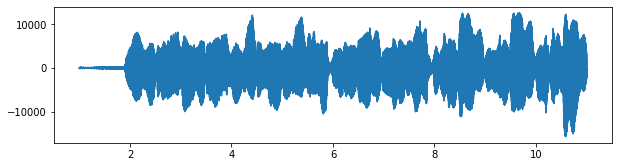

In [3]:

begin = 1 # from seconds
end = 11 # until seconds

# Plot waveform
fig,ax = plt.subplots(figsize=(10,2.5))
passage = passage_extractor(audio,
        [ # List of onsets goes here
        ],
    [begin, end], # Segment between these seconds to plot
    sr=sample_rate
)[0]

# Function below plots only the content in the passage --- keep fixed
onset_visualizer(passage=passage, ax=ax)

In [4]:
# Load model - detect onsets

framerate = 0.01    # The model outputs activations with this frame rate
model = tf.keras.models.load_model(FINAL_MODEL_PATH)
cnn_input = get_segmented_data(audio)
cnn_output = model.predict(cnn_input)
cnn_onsets = get_test_peaks(cnn_output, framerate)
print("Number of onsets detected: ", len(cnn_onsets))

2022-10-18 21:35:20.345929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 21:35:20.353351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 21:35:20.353958: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 21:35:20.354772: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Number of onsets detected:  114


<AxesSubplot:>

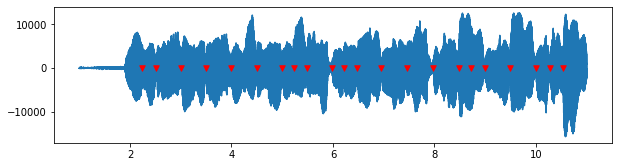

In [5]:
# Plot detections
pred_color = "red"
fig,ax = plt.subplots(figsize=(10,2.5))
passage = passage_extractor(audio,
        [ 
            cnn_onsets      # added here
        ],
    [begin,end],
    sr=sample_rate
)[0]
onset_visualizer(passage=passage, ax=ax, onset_styles={"m":["v"], "c":[pred_color]})

In [6]:
# Evaluate the result

TOL = 0.025 # seconds of tolerance window
metrics = mir_eval.onset.evaluate(true_onsets, cnn_onsets, window=TOL)
print("F-measure: ", metrics["F-measure"])
print("Precision: ", metrics["Precision"])
print("Recall: ", metrics["Recall"])

F-measure:  0.8899521531100479
Precision:  0.8157894736842105
Recall:  0.9789473684210527


<AxesSubplot:>

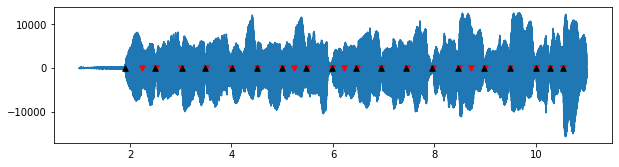

In [7]:
# Plot both detected and true onsets

true_color = "black"
fig,ax = plt.subplots(figsize=(10,2.5))
styles = {"m":["^", "v"], "c":[true_color, pred_color]}
passage = passage_extractor(audio,
        [ 
            true_onsets, 
            cnn_onsets
        ],
    [1,11], # Segment between these seconds to plot
    sr=sample_rate
)[0]
# Function below plots only the content in the passage
onset_visualizer(passage=passage, ax=ax, onset_styles=styles)

In [15]:
# Load note data

with open("datasets/slurtest_add/sc_onsets/" + os.path.basename(audio_fname)[:-4] + "_sc.csv") as file:
    sc_data = file.readlines()
sc_onsets = np.unique(np.array([float(onset.strip()) for onset in sc_data]))

In [31]:
spaces = np.ediff1d(sc_onsets)
margins = []
for note_i in range(len(sc_onsets)):
    if note_i == 0:
        margins.append(spaces[0]/2)
    elif note_i == len(sc_onsets) - 1:
        margins.append(spaces[-1]/2)
    else:
        print(spaces[note_i-1]/2, spaces[note_i]/2)
        margins.append(min(
            spaces[note_i-1]/2, spaces[note_i]/2
        ))
margins = np.array(margins)

0.1745000000000001 0.12749999999999995
0.12749999999999995 0.12199999999999989
0.12199999999999989 0.12750000000000017
0.12750000000000017 0.1279999999999999
0.1279999999999999 0.1100000000000001
0.1100000000000001 0.1279999999999999
0.1279999999999999 0.12749999999999995
0.12749999999999995 0.12199999999999989
0.12199999999999989 0.1275000000000004
0.1275000000000004 0.10449999999999982
0.10449999999999982 0.14550000000000018
0.14550000000000018 0.10999999999999988
0.10999999999999988 0.1280000000000001
0.1280000000000001 0.10999999999999988
0.10999999999999988 0.14500000000000002
0.14500000000000002 0.11649999999999983
0.11649999999999983 0.12749999999999995
0.12749999999999995 0.1160000000000001
0.1160000000000001 0.1280000000000001
0.1280000000000001 0.10999999999999988
0.10999999999999988 0.12199999999999989
0.12199999999999989 0.12200000000000033
0.12200000000000033 0.15649999999999986
0.15649999999999986 0.10450000000000026
0.10450000000000026 0.13949999999999996
0.1394999999999

In [34]:
sc_onsets+margins

array([ 2.0945,  2.3965,  2.646 ,  2.89  ,  3.1505,  3.389 ,  3.609 ,
        3.8825,  4.132 ,  4.376 ,  4.6135,  4.8225,  5.119 ,  5.339 ,
        5.595 ,  5.815 ,  6.1115,  6.3445,  6.599 ,  6.831 ,  7.081 ,
        7.301 ,  7.557 ,  7.801 ,  8.0965,  8.3055,  8.6135,  8.8745,
        9.1295,  9.38  ,  9.624 ,  9.8845, 10.1395, 10.419 , 10.651 ,
       10.912 , 11.15  , 11.382 , 11.638 , 11.87  , 12.1255, 12.3345,
       12.6305, 12.8515, 13.391 , 13.6345, 13.8435, 14.134 , 14.3835,
       14.6215, 14.8545, 15.1325, 15.376 , 15.608 , 15.858 , 16.125 ,
       16.369 , 16.6245, 16.8455, 17.1235, 17.3665, 17.6285, 17.8835,
       18.14  , 18.4065, 18.6615, 18.929 , 19.185 , 19.457 , 19.631 ,
       19.892 , 20.1595, 20.3925, 20.6405, 20.885 , 21.1465, 21.396 ,
       21.64  , 21.907 , 22.151 , 22.4235, 22.6565, 22.923 , 23.155 ,
       23.416 , 23.66  , 23.9735, 24.2165, 26.632 , 27.0445, 27.2535,
       27.566 , 27.8165, 28.0315, 28.2405, 28.542 , 28.774 , 29.0295,
       29.2385, 29.5

<AxesSubplot:>

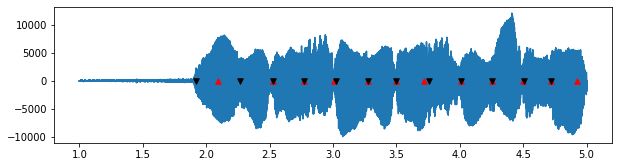

In [ ]:
begin, end = 1,5
fig,ax = plt.subplots(figsize=(10,2.5))
passage = passage_extractor(audio,
        [ 
            sc_onsets, 
            sc_onsets+margins
        ],
    [begin, end], 
    sr=sample_rate
)[0]

# Function below plots only the content in the passage --- keep fixed
onset_visualizer(passage=passage, ax=ax)

[0.1745000000000001,
 0.2549999999999999,
 0.24399999999999977,
 0.24399999999999977,
 0.25500000000000034,
 0.2200000000000002,
 0.2200000000000002,
 0.2549999999999999,
 0.24399999999999977,
 0.24399999999999977,
 0.20899999999999963,
 0.20899999999999963,
 0.21999999999999975,
 0.21999999999999975,
 0.21999999999999975,
 0.21999999999999975,
 0.23299999999999965,
 0.23299999999999965,
 0.2320000000000002,
 0.2320000000000002,
 0.21999999999999975,
 0.21999999999999975,
 0.24399999999999977,
 0.24400000000000066,
 0.20900000000000052,
 0.20900000000000052,
 0.26699999999999946,
 0.2550000000000008,
 0.2550000000000008,
 0.24400000000000155,
 0.24400000000000155,
 0.254999999999999,
 0.2550000000000008,
 0.23199999999999932,
 0.23199999999999932,
 0.24400000000000155,
 0.23199999999999932,
 0.23199999999999932,
 0.23199999999999932,
 0.23199999999999932,
 0.20899999999999963,
 0.20899999999999963,
 0.22100000000000009,
 0.22100000000000009,
 0.2779999999999987,
 0.2090000000000014,
 0